In [ ]:
import tensorflow as tf
from tqdm import tqdm
# import argparse

# parser = argparse.ArgumentParser(description='Select GPU[0-3]:')
# parser.add_argument('--gpu', type=int, default=0,
#                     help='GPU number')
# args = parser.parse_args()
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')


def encoder(shape=(None, 784)):
    inputs = tf.keras.layers.Input(shape)
    outputs = tf.keras.layers.Dense(128, activation='relu')(inputs)
    return tf.keras.Model(inputs, outputs)


def decoder(shape=(None, 128)):
    inputs = tf.keras.layers.Input(shape)
    outputs = tf.keras.layers.Dense(784, activation='sigmoid')(inputs)
    return tf.keras.Model(inputs, outputs)


def autoencoder(shape=(None, 784)):
    inputs = tf.keras.layers.Input(shape)
    encoded = encoder()(inputs)
    decoded = decoder()(encoded)
    return tf.keras.Model(inputs, decoded)


def process_images(image, label):
    noise = 0.25
    image = tf.reshape(image, (-1, 1))/255
    image += noise*tf.random.normal(shape=image.shape)
    image = tf.clip_by_value(image, 0, 1)
    label = tf.reshape(label, (-1, 1))/255
    return image, label


In [9]:
model = autoencoder()
model.summary()
tf.keras.utils.plot_model(
    model, to_file=autoencoder.__name__+'.png', show_shapes=True)

(train_images, train_labels), (test_images,
                                test_labels) = tf.keras.datasets.mnist.load_data()

validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_images))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_images))
validation_ds = tf.data.Dataset.from_tensor_slices(
    (validation_images, validation_images))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(
    validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

train_ds = (train_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
            .map(process_images)
            .shuffle(buffer_size=train_ds_size)
            .batch(batch_size=8, drop_remainder=True))
validation_ds = (validation_ds
                    .map(process_images)
                    .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=32, drop_remainder=True))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 784)]       0         
                                                                 
 model_3 (Functional)        (None, None, 128)         100480    
                                                                 
 model_4 (Functional)        (None, None, 784)         101136    
                                                                 
Total params: 201616 (787.56 KB)
Trainable params: 201616 (787.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training data size: 55000
Test data size: 10000
Validation data size: 5000


In [10]:


for image in train_ds.take(1):
    img,lbl = image[0][0],image[1][0]
    print(img.shape,lbl.shape)

(784, 1) (784, 1)


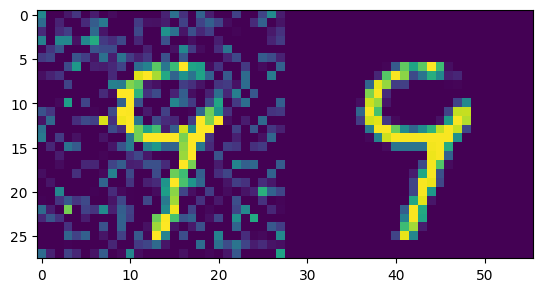

In [11]:
import matplotlib.pyplot as plt
import numpy as np

imgs = np.hstack([img.numpy().reshape(28,28), lbl.numpy().reshape(28,28)])
plt.imshow(imgs)